f1=t  f2=VB f3=P  Vc  Fn   Ap


<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


Idx  f1=t        f2=VB       f3=P       MRR  Vc   Fn  Ap
1   [0.63478834 0.00741263 0.00914768] 18.295 100.0 0.16 1.16
2   [0.5002601  0.00901108 0.01807442] 36.149 100.0 0.2 1.81
3   [0.50158105 0.0089918  0.00939728] 18.795 100.0 0.2 0.94
4   [0.5936562  0.00783131 0.00421243] 8.425 100.0 0.17 0.5
5   [0.62616573 0.0074966  0.00399482] 7.99 100.0 0.16 0.5
6   [0.76375339 0.0063694  0.00331169] 6.623 100.0 0.13 0.51
7   [0.84583133 0.00585844 0.00921483] 18.43 100.0 0.12 1.56
8   [0.72551179 0.00664358 0.0034668 ] 6.934 100.0 0.14 0.5
9   [0.74975505 0.00646688 0.00976149] 19.523 100.0 0.13 1.46
10   [0.6731634  0.00706427 0.00847728] 16.955 100.0 0.15 1.14
11   [0.54166809 0.00844301 0.0164453 ] 32.891 100.0 0.18 1.78
12   [0.73075046 0.00660443 0.01361027] 27.221 100.0 0.14 1.99
13   [0.99291955 0.00513641 0.00980157] 19.603 100.0 0.1 1.95
14   [0.50093501 0.00900112 0.00499713] 9.994 100.0 0.2 0.5
15   [0.57045184 0.00809149 0.00883453] 17.669 100.0 0.18 1.01
16   [0.91179894 0.005

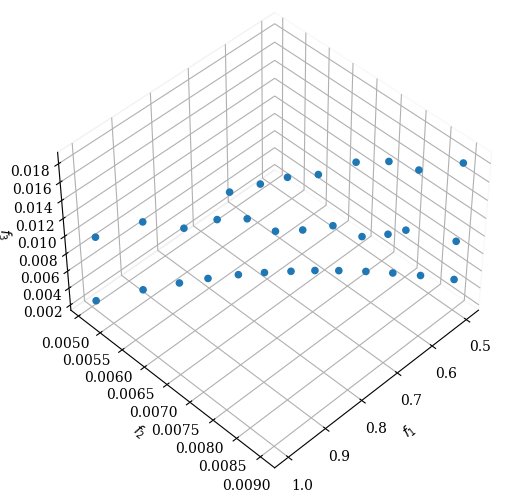

In [1]:
import numpy as np
from pymoo.algorithms.moo.nsga3 import NSGA3

from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem

#from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

class TurningExtraVariablesAndCoeffients:

    def __init__(self, l=50., n=500., tt='DRY', kc=300.):
        self.length = l
        self.n = n
        self.ttype = tt
        self.kc = kc

class MyProblem(ElementwiseProblem):

    def __init__(self, vcmin=100., vcmax=500., fnmin=0.1, fnmax=0.20, apmin=0.5, apmax=2.):
        super().__init__(n_var=3,
                         n_obj=3,
                         n_ieq_constr=0,
                         xl=np.array([vcmin, fnmin, apmin]),
                         xu=np.array([vcmax, fnmax, apmax]))

    def f1(self, l, fn, n): # t
        return l / (fn * n)

    def f20(self, vc, fn): # VB 'DRY'
        return (vc ** 1.52 * fn ** 0.820) / (3.25 * 10000)

    def f21(self, vc, fn): # VB 'MQL'
        return (vc ** 1.42 * fn ** 0.911) / (2.33 * 10000)

    def f3(self, vc, fn, ap, kc): # P
        return (vc * ap * fn * kc) / (60 * 10000)

    def _evaluate(self, x, out, *args, **kwargs):
        vc = x[0]
        fn = x[1]
        ap = x[2]

        tevc = TurningExtraVariablesAndCoeffients()

        f1 = self.f1(tevc.length, fn, tevc.n)
        if tevc.ttype in 'DRY': # or 'MQL'
            f2 = self.f20(vc, fn)
        else:
            f2 = self.f21(vc, fn)
        f3 = self.f3(vc, ap, fn, tevc.kc)
        out["F"] = [f1, f2, f3]
        out["G"] = [] 

problem = MyProblem()

# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

# create the algorithm object
algorithm = NSGA3(pop_size=92,
                  ref_dirs=ref_dirs)

# execute the optimization
print('f1=t ', 'f2=VB', 'f3=P ', 'Vc ', 'Fn  ', 'Ap')
res = minimize(problem,  # get_problem("dtlz1"),
               algorithm,
               seed=None,
               termination=('n_gen', 50))

print('Idx', ' f1=t       ', 'f2=VB      ', 'f3=P      ', 'MRR ', 'Vc  ', 'Fn ', 'Ap')
for i in range(0, len(res.F)):
    s = res.X[i][0]
    fn = res.X[i][1]
    ap = res.X[i][2]
    print(i+1, ' ', res.F[i], round(s*fn*ap, 3), round(res.X[i][0], 0), round(res.X[i][1], 2), round(res.X[i][2], 2))

Scatter().add(res.F).show()
